# 20250624

This note book is used to calculate track score with angular difference between this track and other tracks in the same ROI

Requires: testevals/data_10k.npz or terstevals/data_100k.npz and metrics.py

In [6]:
#loading packages
import torch
import numpy as np
import matplotlib.pyplot as plt
from metrics import calc_match_scores
from tqdm import tqdm

from scipy.spatial import cKDTree

In [7]:
# def a function finding the smallest angular difference between the track and other tracks in the same ROI
def angle_difference_2D(angle_track):
    """
    This function is usded to find out angular difference between the track and other tracks in the same ROI for all of the tracks in this ROI

    This function is about create the cKD tree of the ROI and using this tree to calculate the angular differences 
    Expecting O(log n) complexity

    Inputs: 
        angle_track: angular coordinates of the track in the ROI from data_10k or data_100k(2D numpy array)

    Output:
        mini_angles: angular differences between the track and its cloest neighbor for all the tracks in the ROI
    """
    angle_tracks = angle_track
    #tree = cKDTree(angle_tracks.T)
    mini_angles = np.zeros(angle_track.T.shape[0])

    for idx,tracks in enumerate(angle_track.T):
        #print(tracks)
        #difference, _ = tree.query(tracks, k=2, workers=-1)
        #print(difference[0])
        difference = np.sqrt(np.sum((np.array([tracks]).T - angle_track)**2,axis = 0))
        
        #print(np.sort(difference))
        if len(difference)!=1:
            mini_angles[idx] = np.sort(difference)[1]
        else:
           mini_angles[idx] = np.NaN
        #mini_angles[idx] = difference[1]
    return mini_angles

In [8]:
# def a function finding the smallest angular difference between the track and other tracks in the same ROI
def angle_difference(angle_track):
    """
    This function is usded to find out angular difference between the track and other tracks in the same ROI for all of the tracks in this ROI

    This function is about create the cKD tree of the ROI and using this tree to calculate the angular differences 
    Expecting O(log n) complexity

    Inputs: 
        angle_track: angular coordinates of the track in the ROI from data_10k or data_100k(1D numpy array)

    Output:
        mini_angles: angular differences between the track and its cloest neighbor for all the tracks in the ROI
    """
    angle_tracks = angle_track
    tree = cKDTree(np.array([angle_tracks.T]).T)
    mini_angles = np.zeros(angle_track.shape[0])

    for idx,tracks in enumerate(angle_track):
        #difference, _ = tree.query(tracks, k=2, workers=-1)
        #print(difference[0])
        difference = np.abs(tracks - angle_track)
        #mini_angles[idx] = difference[1]
        #print(np.sort(difference))
        if len(difference)!=1:
            mini_angles[idx] = np.sort(difference)[1]
        else:
            mini_angles[idx] = np.NaN

    return mini_angles




In [ ]:
data = np.load("testevals/data_100k.npz")
print(list(data.keys()))
data = {k: torch.from_numpy(v) for k, v in data.items()}

revolution_pix = 40e-3

match_metric = "tmp"
reco_method = "pred"

angle = "phi"

pred_pix_valid = data[f"{reco_method}_pix_valid"]
pred_sct_valid = data[f"{reco_method}_sct_valid"]
pred_valid = data[f"{reco_method}_valid"]

true_pix_valid = data["sudo_pix_valid"]
true_sct_valid = data["sudo_sct_valid"]
true_valid = data["sudo_valid"]

match_score = calc_match_scores(pred_pix_valid, pred_sct_valid, pred_valid, true_pix_valid, true_sct_valid, true_valid, match_metric)

d_angle = []
scores = []

for idx in tqdm(range(match_score.shape[0])):
    #print(data[f"sudo_{angle}"][idx].shape)
    #print(pred_valid.shape)
    #print(data[f"sudo_{angle}"][idx][pred_valid[idx]])
    #mini_angles_phi = angle_difference(data[f"sudo_phi"][idx][pred_valid[idx]].numpy())
    #mini_angles_eta = angle_difference(data[f"sudo_eta"][idx][pred_valid[idx]].numpy())
    datas = np.stack((data[f"sudo_phi"][idx][pred_valid[idx]].numpy(),data[f"sudo_eta"][idx][pred_valid[idx]].numpy()),axis=0)
    #print(datas)
    mini_angle = angle_difference_2D(datas)
    #print(mini_angles)
    #print(mini_angles.shape)
    #print(r_xy)

    #tqdm.write(f"Minima radius: {np.min(r_xy)}")
    #tqdm.write(f"Minima angle: {minima_angle}")

    for idx2,angles in enumerate(mini_angle):
        hits = np.stack([data["pix_x"][idx][pred_pix_valid[idx][idx2]],data["pix_y"][idx][pred_pix_valid[idx][idx2]]],axis = 0)
        r_xy = np.sqrt(np.sum(np.square(hits.T),axis = 1))
        #print(hits)
        #print(r_xy)
        #if data[f"sudo_phi"][idx][pred_valid[idx]][idx2] == 0: continue
        #if data[f"sudo_eta"][idx][pred_valid[idx]][idx2] == 0: continue
        if r_xy.shape[0] == 0: continue
        if angles*np.max(r_xy) < revolution_pix: continue
        d_angle.append(angles)
        #d_angle.append(np.sqrt(np.square(angles)+ np.square(mini_angles_eta[idx2])))
        scores.append(np.max(match_score[idx][idx2].numpy()))

['pix_r', 'pix_eta', 'pix_phi', 'pix_theta', 'pix_x', 'pix_y', 'pix_z', 'pix_u', 'pix_v', 'pix_s', 'pix_roi_eta', 'pix_roi_phi', 'pix_roi_z0', 'pix_deta', 'pix_dphi', 'pix_dR', 'pix_mod_norm_phi', 'pix_mod_norm_theta', 'pix_mod_x', 'pix_mod_y', 'pix_mod_z', 'pix_mod_eta', 'pix_mod_phi', 'pix_mod_loc_x', 'pix_mod_loc_y', 'pix_logcharge', 'pix_lshift', 'pix_logchargemat', 'pix_pitches', 'pix_valid', 'sct_r', 'sct_eta', 'sct_phi', 'sct_theta', 'sct_x', 'sct_y', 'sct_z', 'sct_u', 'sct_v', 'sct_s', 'sct_roi_eta', 'sct_roi_phi', 'sct_roi_z0', 'sct_deta', 'sct_dphi', 'sct_dR', 'sct_mod_norm_phi', 'sct_mod_norm_theta', 'sct_mod_x', 'sct_mod_y', 'sct_mod_z', 'sct_mod_loc_x', 'sct_mod_loc_y', 'sct_logcharge', 'sct_side', 'sct_width', 'sct_valid', 'sudo_pt', 'sudo_eta', 'sudo_phi', 'sudo_theta', 'sudo_z0', 'sudo_d0', 'sudo_q', 'sudo_qop', 'sudo_deta', 'sudo_dphi', 'sudo_dz0', 'sudo_bhadpt', 'sudo_valid', 'sisp_pt', 'sisp_eta', 'sisp_phi', 'sisp_z0', 'sisp_d0', 'sisp_q', 'sisp_qop', 'sisp_deta', '

  0%|          | 122/100000 [00:00<01:22, 1208.95it/s]

[[0.01366593 0.02170808 0.03750975 0.05251776]
 [0.02916726 0.04583512 0.07863623 0.10955068]]
[[0.01387564 0.02198312 0.03792934 0.05301194]
 [0.02903116 0.0456156  0.07832751 0.10919813]]
[[0.01387564 0.02193132 0.03780713 0.05280787]
 [0.02903116 0.04563425 0.07838052 0.10931109]]
[[0.01545545 0.02414067 0.04417338 0.06071055]
 [0.02800591 0.04345968 0.07894938 0.10806652]]
[[0.01442088 0.02270451 0.03922211 0.0548105 ]
 [0.02867732 0.04485169 0.07700254 0.10731833]]
[[0.01404341 0.02217852 0.03833407 0.05356018]
 [0.02892229 0.04538646 0.07788255 0.10857859]]
[[0.02336707 0.04042929 0.05902971]
 [0.04413491 0.07573276 0.10989071]]
[[0.01539953 0.02401927 0.04382674 0.06009145]
 [0.0280422  0.04351453 0.07925196 0.10862722]]
[[0.06151626 0.06175742 0.01423215 0.03517605 0.03510107]
 [0.10720672 0.10691945 0.0287998  0.08094654 0.08101284]]
[[0.01393436 0.03797298 0.05314364]
 [0.02899306 0.07826459 0.10923781]]
[[0.01370787 0.02163257 0.03745109 0.05242822]
 [0.02914004 0.04561584 0

  0%|          | 368/100000 [00:00<01:24, 1182.14it/s]

[[0.02527952 0.04112798 0.07009022 0.09636958]
 [0.01983671 0.03236203 0.055229   0.07601614]]
[[0.02547435 0.04134057 0.0695189  0.09693302]
 [0.0195163  0.0317693  0.05359961 0.07485884]]
[[0.02504571 0.04095723 0.06972918 0.09590197]
 [0.02022121 0.03311798 0.05634715 0.07743262]]
[[0.02525354 0.04117699 0.06919627 0.09650692]
 [0.01987943 0.03244998 0.05459882 0.07613985]]
[[0.02530549 0.04121004 0.0692431  0.09654706]
 [0.01979399 0.03230367 0.05440377 0.07594257]]
[[0.02499375 0.04095729 0.06869701 0.09578612]
 [0.02030665 0.03334866 0.05601386 0.07818374]]
[[0.02541807 0.04127908 0.06946663 0.09689697]
 [0.01960886 0.03193482 0.05366155 0.07482077]]
[[0.02541807 0.04127908 0.06938068 0.09673502]
 [0.01960886 0.03193482 0.05389651 0.07526758]]
[[0.02533147 0.04119451 0.0702493  0.09660301]
 [0.01975127 0.03217201 0.0548863  0.07546994]]
[[0.04112687 0.02522756 0.07005796 0.09632488]
 [0.03254119 0.01992215 0.0555601  0.07647491]]
[[0.02541807 0.04127908 0.06935908 0.09665746]
 [0

  1%|          | 626/100000 [00:00<01:21, 1223.74it/s]

[[ 0.03057818  0.04390322  0.04853252  0.11076316]
 [-0.01478018 -0.02086208 -0.02301709 -0.05136053]]
[[ 0.02964557  0.04687873  0.10739711]
 [-0.01568585 -0.0243529  -0.0550268 ]]
[[ 0.04661546  0.02952003  0.10714194]
 [-0.02454361 -0.01580777 -0.05526686]]
[[ 0.02956307  0.04668694  0.10714612]
 [-0.01576597 -0.02445865 -0.05516625]]
[[ 0.02956307  0.04668694  0.10733797]
 [-0.01576597 -0.02445865 -0.05496922]]
[[ 0.02956307  0.04668694  0.10703917]
 [-0.01576597 -0.02445865 -0.05530636]]
[[ 0.04625155  0.10659673]
 [-0.02480849 -0.05578279]]
[[ 0.04625155  0.10621305  0.11096879]
 [-0.02480849 -0.05617686 -0.05865457]]
[[ 0.04625155  0.10648413  0.11126568]
 [-0.02480849 -0.05590577 -0.05842536]]
[[ 0.1061084   0.11082767]
 [-0.05628433 -0.05875834]]
[]
[[-0.02482814]
 [-0.020579  ]]
[[-0.02473397 -0.04076138 -0.06899715 -0.09473859]
 [-0.02073386 -0.03412457 -0.05773959 -0.07924445]]
[[-0.02470799 -0.0407464  -0.06899865 -0.09477189]
 [-0.02077658 -0.03412118 -0.05763499 -0.07901

  1%|          | 871/100000 [00:00<01:26, 1144.78it/s]

[[-0.01608807 -0.01826535 -0.02432849 -0.04507551 -0.06166189]
 [-0.02759536 -0.0313715  -0.04179725 -0.07753229 -0.10600796]]
[[-0.01608807 -0.01826535 -0.02422158 -0.04461081 -0.06076817]
 [-0.02759536 -0.0313715  -0.04190247 -0.07815251 -0.10711786]]
[[-0.01886285 -0.02532626 -0.04668754 -0.0638319 ]
 [-0.03038891 -0.04081518 -0.07538074 -0.10331302]]
[[-0.01886285 -0.02532626 -0.04668754 -0.06396674]
 [-0.03038891 -0.04081518 -0.07538074 -0.10314556]]
[[-0.01886285 -0.02532626 -0.04668754 -0.0638319 ]
 [-0.03038891 -0.04081518 -0.07538074 -0.10331302]]
[[-0.01886285 -0.02532626 -0.04668754 -0.06406081]
 [-0.03038891 -0.04081518 -0.07538074 -0.10302873]]
[[-0.01886285 -0.02532626 -0.04668754 -0.0638319 ]
 [-0.03038891 -0.04081518 -0.07538074 -0.10331302]]
[[-0.01886285 -0.02521936 -0.04635182 -0.06346501]
 [-0.03038891 -0.04092041 -0.07582881 -0.10376867]]
[[-0.01886285 -0.02532626 -0.04668754 -0.0638319 ]
 [-0.03038891 -0.04081518 -0.07538074 -0.10331302]]
[[-0.01886285 -0.02532626

  1%|          | 1110/100000 [00:00<01:24, 1168.08it/s]

[]
[]
[]
[]
[]
[[0.03125628 0.04853186 0.08298647 0.11611445 0.08298464]
 [0.00819771 0.01290386 0.02229981 0.03131662 0.02219983]]
[[-0.03203183 -0.05472797 -0.07725459]
 [ 0.03878411  0.06715947  0.09541013]]
[[-0.03383007 -0.05781706 -0.08202633]
 [ 0.0380971   0.06586328  0.09383486]]
[[-0.02194343 -0.03194253 -0.05460885 -0.07714231]
 [ 0.02631491  0.03883056  0.06722022  0.09546898]]
[[-0.02263118 -0.03295085 -0.05632526 -0.0797733 ]
 [ 0.02608551  0.03845766  0.06652959  0.09464006]]
[[-0.02206201 -0.03212799 -0.0549386  -0.0776622 ]
 [ 0.02627536  0.0387556   0.06707997  0.09528924]]
[[-0.0232715  -0.03386439 -0.05781172 -0.08190636]
 [ 0.02587193  0.03811687  0.06591542  0.09395074]]
[[-0.02146069 -0.0323838  -0.05766131 -0.07685003]
 [-0.02611677 -0.03951007 -0.0705592  -0.09416453]]
[[-0.02172048 -0.03278953 -0.05837277 -0.07793003]
 [-0.02568955 -0.03882033 -0.0692572  -0.09252025]]
[[-0.02147468 -0.0323916  -0.05768952 -0.07692088]
 [-0.02609376 -0.03953893 -0.07060383 -0.

  1%|▏         | 1348/100000 [00:01<01:29, 1105.90it/s]

[[0.02342856 0.03538242 0.0618348  0.08725497]
 [0.02288061 0.03459838 0.06046455 0.08530406]]
[[0.08719905]
 [0.08533315]]
[[0.0618657 ]
 [0.06034917]]
[[0.0618657 ]
 [0.06034917]]
[[0.0618657  0.08719905]
 [0.06034917 0.08533315]]
[[0.03144619 0.04873018 0.0876191  0.12113067]
 [0.00625698 0.00991025 0.01811863 0.0252159 ]]
[[0.0018893  0.00337784 0.00601881 0.00838801]
 [0.03192357 0.05252993 0.08880873 0.1214562 ]]
[[0.00126105 0.00246473 0.00450905 0.00632492]
 [0.03200369 0.05299125 0.08947494 0.12231059]]
[[0.00126105 0.00222198 0.00409377 0.00575843]
 [0.03200369 0.05312527 0.08966888 0.12255587]]
[[0.00117839 0.00234331 0.00442318 0.00642499]
 [0.03201423 0.05303413 0.08946779 0.12220791]]
[[0.00253407 0.00294978 0.00443677 0.00792312 0.01103441]
 [0.03184133 0.03612174 0.05191248 0.08786373 0.12020691]]
[[0.00228608 0.00267715 0.00411501 0.00751398 0.01077145]
 [0.03187296 0.03629867 0.05215892 0.0881706  0.12048012]]
[[0.00126105 0.00246473 0.00450905 0.00632492]
 [0.0320036

  2%|▏         | 1578/100000 [00:01<01:36, 1024.39it/s]

[[ 0.01840982  0.02722673  0.04965914  0.05036293]
 [-0.02749355 -0.04031024 -0.07322298 -0.07421999]]
[[ 0.02062327  0.03052785  0.05338603  0.07683417]
 [-0.02675525 -0.03905044 -0.06740556 -0.09645856]]
[[ 0.02080509  0.03078476  0.05377319  0.07733547]
 [-0.0266946  -0.038929   -0.0672081  -0.0962487 ]]
[[ 0.02035449  0.03019085  0.052828    0.07596649]
 [-0.0268449  -0.03914905 -0.06758297 -0.09667388]]
[[ 0.02035449  0.03019085  0.052828    0.07569794]
 [-0.0268449  -0.03914905 -0.06758297 -0.09676421]]
[[ 0.02035449  0.05584374  0.07460987  0.02979977]
 [-0.0268449  -0.07288124 -0.09719062 -0.03931626]]
[[-0.03493165]
 [-0.0025946 ]]
[[-0.03493165 -0.05117906]
 [-0.0025946  -0.00361999]]
[[-0.03493165 -0.05117906]
 [-0.0025946  -0.00361999]]
[[-0.03493165 -0.05117906]
 [-0.0025946  -0.00361999]]
[[-0.03493165]
 [-0.0025946 ]]
[[-0.03487466 -0.05109356 -0.09067808 -0.12189345]
 [-0.00243909 -0.00338507 -0.00564744 -0.00752444]]
[[-0.03493165 -0.05117906 -0.12205641 -0.09082132]
 

  2%|▏         | 1831/100000 [00:01<01:26, 1138.07it/s]

[[-0.02478593 -0.04100459 -0.06901186 -0.09542755]
 [-0.02064842 -0.03412824 -0.05748162 -0.07952185]]
[[-0.0250587  -0.04121367 -0.06952637 -0.09618606]
 [-0.02019984 -0.03315027 -0.05583505 -0.07713963]]
[[-0.0250587  -0.04121367 -0.06952637 -0.09618606]
 [-0.02019984 -0.03315027 -0.05583505 -0.07713963]]
[[-0.02483789 -0.04102266 -0.06909931 -0.09556897]
 [-0.02056298 -0.03397854 -0.05714206 -0.07898945]]
[[-0.02556528 -0.04156143 -0.0703881  -0.09742296]
 [-0.01936678 -0.03135785 -0.05288197 -0.07296751]]
[[-0.02538343 -0.04141878 -0.06996373 -0.09673547]
 [-0.01966583 -0.03212015 -0.05432121 -0.07524142]]
[[-0.09564607]
 [-0.07877793]]
[[0.00074303 0.00294242 0.00420513]
 [0.03206976 0.09037618 0.12418868]]
[[0.00213729 0.00253036 0.00379532 0.00699917 0.00975918]
 [0.03189193 0.03639393 0.05166811 0.08844724 0.12168627]]
[[0.00203809 0.00358584 0.00636219 0.00882678]
 [0.03190459 0.05180649 0.08877735 0.12215308]]
[[0.00074303 0.00176065 0.00326466 0.00445433]
 [0.03206976 0.0527

  2%|▏         | 2068/100000 [00:01<01:24, 1162.33it/s]

[[ 0.05031852  0.08582555  0.11896937]
 [-0.01068374 -0.01792781 -0.02450448]]
[[ 0.08582555]
 [-0.01792781]]
[]
[[ 0.08582555]
 [-0.01792781]]
[[ 0.08582555]
 [-0.01792781]]
[[ 0.03143908  0.05031852  0.0860245   0.11924078]
 [-0.00693626 -0.01068374 -0.01763822 -0.02412265]]
[[ 0.03143908  0.05031852  0.08586126  0.11890795]
 [-0.00693626 -0.01068374 -0.01791927 -0.02470032]]
[[0.01127524 0.01784297 0.04187756]
 [0.03071875 0.04818067 0.1120621 ]]
[[0.01127524 0.04211617 0.04404601]
 [0.03071875 0.11188025 0.11694039]]
[[0.0112333  0.01778952 0.04189744]
 [0.03074597 0.04823328 0.11204694]]
[[0.03084479 0.04938543 0.08411823 0.11215071]
 [0.01240263 0.02003909 0.03430606 0.04578472]]
[[0.03074497 0.04372809 0.04951525 0.07925951 0.11190875]
 [0.01342275 0.01921175 0.02180942 0.03500528 0.049502  ]]
[[0.03066462 0.04349522 0.07896365 0.11170349]
 [0.01424383 0.02031249 0.03713491 0.05267049]]
[[-0.03131063 -0.05048128 -0.08438908 -0.11725804]
 [ 0.00728679  0.01206608  0.02042789  0.0

  2%|▏         | 2316/100000 [00:02<01:22, 1184.07it/s]

[[-0.03558002 -0.05192866 -0.03551407 -0.1199981  -0.05204267]
 [-0.00436392 -0.00567948 -0.00418395 -0.01573854 -0.00599272]]
[[-0.05204267]
 [-0.00599272]]
[[-0.00440968 -0.01071086 -0.01433896]
 [ 0.03272692  0.08969535  0.124238  ]]
[[-0.0037153  -0.00902903 -0.01217891]
 [ 0.03263836  0.08917937  0.12352029]]
[[-0.00528591 -0.01332158 -0.01727633]
 [ 0.03283867  0.090226    0.11945264]]
[[ 0.01153231  0.01318857  0.01799909  0.03244955]
 [-0.02978754 -0.03384656 -0.04557138 -0.08110996]]
[[ 0.01314497  0.02081521  0.03750702]
 [-0.02924964 -0.0453475  -0.08075219]]
[[ 0.01245722  0.0196439   0.03556421]
 [-0.02947904 -0.04544062 -0.08084881]]
[[ 0.01295524  0.02046631  0.03722092]
 [-0.02931292 -0.04537524 -0.08089989]]
[[ 0.01327777  0.02101458  0.0380094 ]
 [-0.02920534 -0.04533165 -0.08069521]]
[[ 0.01302639  0.02054107  0.03716214]
 [-0.02928919 -0.04536929 -0.08076516]]
[[ 0.0130501   0.02064076  0.03730911]
 [-0.02928128 -0.04536137 -0.08071338]]
[[ 0.01323983  0.02096473  0

  3%|▎         | 2686/100000 [00:02<01:20, 1208.26it/s]

[[-0.02367328 -0.03925474 -0.06616867 -0.09006062]
 [ 0.02148563  0.03632468  0.06203063  0.08491456]]
[[-0.02305154 -0.02593555 -0.03779722 -0.06390251 -0.08719748]
 [ 0.02208941  0.02498334  0.03685274  0.06291856  0.08616889]]
[[-0.02293795 -0.02570827 -0.03745925 -0.06341629 -0.08648948]
 [ 0.02219972  0.02505914  0.03701885  0.06318159  0.08658794]]
[[-0.02570827 -0.03745925 -0.06318997 -0.08625723]
 [ 0.02505914  0.03701885  0.06328842  0.08669621]]
[[-0.03745925 -0.06318997]
 [ 0.03701885  0.06328842]]
[[-0.03745925 -0.06318997]
 [ 0.03701885  0.06328842]]
[[-0.04154876 -0.02543539 -0.0704796  -0.09671125]
 [-0.03189321 -0.01958039 -0.05405433 -0.07410275]]
[[-0.02536611 -0.04149801 -0.0703759  -0.09655267]
 [-0.01969431 -0.03212951 -0.0543755  -0.07460851]]
[[-0.025903   -0.04185235 -0.07123967 -0.09779015]
 [-0.0188114  -0.03027022 -0.05134426 -0.07032613]]
[[-0.024695   -0.03713016 -0.04096493]
 [-0.02079795 -0.03127944 -0.0344781 ]]
[[-0.02504571 -0.04119384 -0.06962388 -0.0

  3%|▎         | 2808/100000 [00:02<01:22, 1184.74it/s]

[[ 0.04362464  0.02776242  0.07438347  0.10454929]
 [-0.02709478 -0.01751461 -0.04550033 -0.06355747]]
[[ 0.02856351  0.04506993  0.07650519  0.10761143]
 [-0.01673666 -0.02598037 -0.04359744 -0.06106221]]
[[ 0.02792383  0.04395457  0.07485777  0.10524505]
 [-0.01735786 -0.02686781 -0.04513086 -0.06306624]]
[[ 0.02799557  0.04416685  0.0750006   0.10538177]
 [-0.01728819 -0.0266789  -0.04495282 -0.06287728]]
[[ 0.02799557  0.04416685  0.07517146  0.10568108]
 [-0.01728819 -0.0266789  -0.04480637 -0.06265107]]
[[ 0.02799557  0.04416685  0.07517146  0.10568108]
 [-0.01728819 -0.0266789  -0.04480637 -0.06265107]]
[[ 0.07379522  0.10309852]
 [-0.04604274 -0.06474538]]
[[ 0.07379522  0.10309852  0.04376622]
 [-0.04604274 -0.06474538 -0.02699185]]
[]
[[ 0.07379522  0.10309852]
 [-0.04604274 -0.06474538]]
[[-0.00783601 -0.01103849 -0.01973268 -0.02649037]
 [-0.03295071 -0.04724166 -0.08642122 -0.11721603]]
[[-0.00716494 -0.0100689  -0.01814075 -0.02442011]
 [-0.03338622 -0.04776116 -0.0875035

  3%|▎         | 3046/100000 [00:02<01:30, 1067.38it/s]

[[-0.02595496 -0.04132327 -0.07042736 -0.09758796]
 [-0.01872595 -0.02971501 -0.0505828  -0.07007603]]
[[-0.02592898 -0.04233415 -0.07141692 -0.09860686]
 [-0.01876867 -0.03050718 -0.05127012 -0.0706452 ]]
[[-0.02639659 -0.03005105 -0.04265008 -0.07202303 -0.09929618]
 [-0.01799969 -0.02051388 -0.02914327 -0.04944297 -0.06858227]]
[[-0.0714183  -0.10317872]
 [-0.04751382 -0.06868286]]
[[-0.0714183 ]
 [-0.04751382]]
[[-0.0714183  -0.10322031]
 [-0.04751382 -0.06847192]]
[[-0.0714183  -0.10322031]
 [-0.04751382 -0.06847192]]
[[-0.0714183  -0.10322031]
 [-0.04751382 -0.06847192]]
[[-0.0714183  -0.10317872]
 [-0.04751382 -0.06868286]]
[[-0.12474712 -0.04870374 -0.08910579 -0.11960229 -0.03230271 -0.04808042
  -0.0531845  -0.08739307 -0.12241772]
 [ 0.01519875  0.00542912  0.01039142  0.01412418  0.00457951  0.00709117
   0.00791977  0.01339588  0.01904942]]
[[-0.12474712 -0.04870374 -0.08910579 -0.11960229 -0.03230271 -0.04808042
  -0.0531845  -0.08739307 -0.12241772]
 [ 0.01519875  0.0054

  3%|▎         | 3283/100000 [00:02<01:26, 1116.58it/s]

[[ 0.01199832]
 [-0.08947874]]
[]
[[ 0.00517846  0.00837054  0.01461649]
 [-0.03282497 -0.05063899 -0.08504413]]
[[ 0.00422782  0.00685389  0.0125871 ]
 [-0.03270373 -0.05046155 -0.0896256 ]]
[[ 0.00440968  0.00709108  0.01285396]
 [-0.03272692 -0.05048764 -0.08966061]]
[[-0.01088225 -0.01467557 -0.02627291 -0.03460258]
 [ 0.03355242  0.04635276  0.08680872  0.11702172]]
[]
[[-0.03111019 -0.0478855  -0.0830425  -0.11630618]
 [-0.00969058 -0.01473603 -0.0253493  -0.0353871 ]]
[[-0.03112967 -0.04786463 -0.08303056 -0.11626031]
 [-0.00949153 -0.01440753 -0.02469941 -0.03441318]]
[[-0.03119054 -0.04780068 -0.0830007  -0.11615444]
 [-0.0088695  -0.01340123 -0.02307468 -0.03216567]]
[[-0.03116294 -0.04783271 -0.08301587 -0.1162109 ]
 [-0.00915148 -0.01390521 -0.02389954 -0.03336435]]
[[-0.03116294 -0.04783271 -0.08301587 -0.1162109 ]
 [-0.00915148 -0.01390521 -0.02389954 -0.03336435]]
[[-0.04781495 -0.03117836 -0.08300576 -0.11617209]
 [-0.01362577 -0.0089939  -0.02334963 -0.03254026]]
[[-0.

  4%|▎         | 3508/100000 [00:03<01:29, 1081.36it/s]

[[0.03126845 0.0486957  0.08338859 0.11720874]
 [0.0080733  0.01281829 0.02239245 0.03184073]]
[[0.04863145]
 [0.01224621]]
[[-0.001037   -0.00124995 -0.00163136 -0.00180667]
 [ 0.03229678  0.04813073  0.08602669  0.12121245]]
[[-0.00158258 -0.00213087 -0.00336787 -0.00446392]
 [ 0.03236636  0.04831506  0.08650055  0.12078304]]
[[-0.00073941 -0.00085843 -0.001149   -0.00146828]
 [ 0.03225882  0.04804881  0.08589506  0.11989325]]
[[-0.07785717 -0.11122113]
 [-0.04014821 -0.05725295]]
[[-0.03065732 -0.04346579 -0.07840992 -0.11162414]
 [-0.01431847 -0.02022895 -0.03649693 -0.05214655]]
[[-0.03050914 -0.0430472  -0.07793387 -0.11129142]
 [-0.01583266 -0.02208227 -0.03969503 -0.05647547]]
[[-0.03050914 -0.04300645 -0.07785717 -0.11122113]
 [-0.01583266 -0.02226272 -0.04014821 -0.05725295]]
[[-0.03050914 -0.04300645 -0.07785717 -0.11122113]
 [-0.01583266 -0.02226272 -0.04014821 -0.05725295]]
[[0.00931795 0.01519347]
 [0.03198897 0.05151182]]
[[0.0095766  0.01410052 0.01557948]
 [0.03182112 

  4%|▎         | 3723/100000 [00:03<01:34, 1023.49it/s]

[[-0.01812523 -0.02888973 -0.04717462 -0.0660191 ]
 [ 0.02758847  0.04470558  0.07376067  0.10370371]]
[[-0.01857582 -0.04853786 -0.06812853]
 [ 0.02743817  0.07344198  0.10328798]]
[[-0.01698688 -0.02667173 -0.04347438 -0.0603531 ]
 [ 0.02796817  0.04488191  0.07462569  0.10482041]]
[[-0.01781693 -0.02829162 -0.04624956 -0.06469458]
 [ 0.0276913   0.04475313  0.07397693  0.10396477]]
[]
[[ 0.04886615]
 [-0.01296728]]
[[ 0.0308748   0.04886615  0.08343983  0.08817346  0.08775245]
 [-0.00847612 -0.01296728 -0.02134631 -0.0224875  -0.02296584]]
[[ 0.0308748   0.04886615  0.08343983  0.08817346  0.14067142]
 [-0.00847612 -0.01296728 -0.02134631 -0.0224875  -0.03486359]]
[[ 0.04886615  0.1400011   0.08775245]
 [-0.01296728 -0.03618317 -0.02296584]]
[]
[[-0.00068982 -0.00079324 -0.00105448 -0.00129975]
 [ 0.0322525   0.04872661  0.08643151  0.12040234]]
[[-0.00168178 -0.00231746 -0.00388679 -0.00543493]
 [ 0.03237901  0.04901024  0.08713142  0.12152381]]
[[-0.001285   -0.00167073 -0.0024192

  4%|▍         | 3965/100000 [00:03<01:26, 1112.37it/s]

[[ 0.02500046  0.03856896  0.07004963  0.0965338 ]
 [-0.02019679 -0.03064804 -0.05487834 -0.07521591]]
[[ 0.02537709  0.03919963  0.07019699  0.09796679]
 [-0.01983104 -0.03019702 -0.05346688 -0.07439567]]
[[ 0.02525155  0.03901012  0.07088938  0.09769186]
 [-0.01995295 -0.03031954 -0.05436656 -0.07452169]]
[[ 0.02569991  0.03981971  0.07142328  0.09976128]
 [-0.01951754 -0.02977337 -0.0527715  -0.07338345]]
[[ 0.02581948  0.03992004  0.07168387  0.10014647]
 [-0.01940142 -0.02967128 -0.05255965 -0.0730719 ]]
[[-0.04865783 -0.07854947]
 [ 0.02289277  0.04209689]]
[[-0.04865783 -0.07854947]
 [ 0.02289277  0.04209689]]
[[-0.11766237 -0.1176768 ]
 [-0.04032878 -0.0408637 ]]
[[-0.03103714 -0.04910293 -0.11747191]
 [-0.01043701 -0.01619927 -0.03750962]]
[[0.02222705 0.0331304  0.05897813 0.08325868]
 [0.02485649 0.03700735 0.06588283 0.09302631]]
[[0.02206859 0.03297217 0.05875682 0.07964413]
 [0.02511709 0.03746862 0.06662218 0.09016758]]
[[0.05927506 0.02227468 0.03327045 0.08370622]
 [0.

  4%|▍         | 4187/100000 [00:03<01:27, 1096.09it/s]

[[-0.04287301 -0.07396681 -0.10343589]
 [ 0.0263631   0.04619848  0.06488533]]
[[-0.04186647 -0.07232093 -0.07671931 -0.10095251 -0.02761894]
 [ 0.02709631  0.04758297  0.05050322  0.06678393  0.01765394]]
[[-0.04163704 -0.07588857 -0.09973279]
 [ 0.02729021  0.05106072  0.0678203 ]]
[[-0.07346641 -0.02793878 -0.0424819  -0.10276661]
 [ 0.046639    0.01734334  0.02666654  0.06540945]]
[[-0.07346641 -0.02793878 -0.0424819  -0.10257022]
 [ 0.046639    0.01734334  0.02666654  0.06557745]]
[[-0.02793878]
 [ 0.01734334]]
[]
[[-0.03330912 -0.04969041 -0.08668753 -0.12218667]
 [ 0.0018331   0.00302137  0.00570569  0.00829624]]
[[ 0.03079739  0.04839157  0.0871524   0.11953299]
 [-0.00868738 -0.01330087 -0.02351601 -0.03207494]]
[[ 0.03120167  0.04968749  0.08396698]
 [-0.00758413 -0.01154078 -0.01923216]]
[[ 0.03099523  0.04896965  0.08311824  0.08836247  0.12119993]
 [-0.00814749 -0.01251573 -0.02073392 -0.02201889 -0.02988775]]
[[ 0.03105544  0.04914752  0.08330274]
 [-0.00798318 -0.0122741

  4%|▍         | 4428/100000 [00:03<01:26, 1105.72it/s]

[[-0.02431499 -0.03517642 -0.0597097 ]
 [ 0.02552387  0.0374882   0.06462082]]
[[-0.02351657 -0.03407743 -0.05790542]
 [ 0.02579019  0.03790396  0.06536055]]
[[-0.02394345 -0.03468058 -0.05996279]
 [ 0.0256478   0.03759133  0.06561764]]
[[-0.0234138  -0.03390368 -0.0584753 ]
 [ 0.02582447  0.03793951  0.06633762]]
[[-0.02363515 -0.03437007 -0.05949549]
 [ 0.02575064  0.03775927  0.06589358]]
[[-0.0234138  -0.03390368 -0.05853714]
 [ 0.02582447  0.03793951  0.06629104]]
[[ 0.04379815  0.07638991  0.10752443]
 [-0.02554771 -0.04393839 -0.06147239]]
[[ 0.04379815  0.07656971  0.1077559 ]
 [-0.02554771 -0.04374551 -0.06124165]]
[[ 0.04242546  0.07414281  0.10412405]
 [-0.02659239 -0.04594481 -0.06422523]]
[[ 0.07845852  0.11063536]
 [-0.04206979 -0.05891813]]
[[ 0.04379815  0.07638991  0.10752443]
 [-0.02554771 -0.04393839 -0.06147239]]
[[ 0.04379815  0.07622968  0.10715206]
 [-0.02554771 -0.04407797 -0.0617673 ]]
[[ 0.04379815  0.07638991  0.10752443]
 [-0.02554771 -0.04393839 -0.06147239

  5%|▍         | 4677/100000 [00:04<01:22, 1153.41it/s]

[[-0.02648751 -0.03007443 -0.04261307 -0.07233947 -0.10318917]
 [-0.01785016 -0.02027502 -0.02858388 -0.04836297 -0.06887352]]
[[-0.02648751 -0.03007443 -0.04261307 -0.07232336 -0.10316969]
 [-0.01785016 -0.02027502 -0.02858388 -0.04846286 -0.06906503]]
[[-0.03007443 -0.02644855 -0.0425548  -0.07226012 -0.10413317]
 [-0.02027502 -0.01791425 -0.02873731 -0.04852125 -0.06981552]]
[[0.04876526 0.1219108 ]
 [0.01000822 0.02722543]]
[[0.03144132 0.04876526 0.08854518 0.12153783]
 [0.00630674 0.01000822 0.01853139 0.02556947]]
[[-0.00760877 -0.0193099  -0.02781981]
 [ 0.03313493  0.08534633  0.12112678]]
[[-0.00894792 -0.02227844 -0.03020994]
 [ 0.03330572  0.08556049  0.11623055]]
[[-0.00879913 -0.0217684  -0.02940278]
 [ 0.03328674  0.08563419  0.11636358]]
[[-0.00822875 -0.02025505 -0.02853462]
 [ 0.033214    0.08544216  0.12124793]]
[[-0.00780716 -0.0190845  -0.02675736]
 [ 0.03316023  0.08533892  0.12096227]]
[[-0.00855113 -0.02112404 -0.0285055  -0.02973854]
 [ 0.03325511  0.08554571  

  5%|▍         | 4793/100000 [00:04<01:26, 1106.21it/s]

[[-0.08405234 -0.11719231]
 [-0.02615232 -0.0362714 ]]
[[-0.0317866  -0.05212145 -0.08539482 -0.11909527]
 [ 0.00598792  0.01017951  0.01702389  0.02394068]]
[[-0.0317866  -0.05090081 -0.05214155 -0.08538968 -0.11905511]
 [ 0.00598792  0.00994516  0.01019431  0.01710713  0.02411035]]
[[-0.03173155 -0.05197631 -0.08519073 -0.11879837]
 [ 0.00613815  0.01038311  0.01739672  0.02446213]]
[[-0.03215647 -0.04733048 -0.05210062 -0.08710401 -0.12166646]
 [ 0.00497856  0.00756314  0.0083946   0.0142663   0.01991301]]
[[-0.0317866  -0.05090081 -0.08536053 -0.11895314]
 [ 0.00598792  0.00994516  0.01720553  0.02435002]]
[[-0.03173155 -0.05189356 -0.08509734 -0.11867451]
 [ 0.00613815  0.01050845  0.01757367  0.02469864]]
[[-0.0832677  -0.08823904 -0.12098889]
 [ 0.02130655  0.02260488  0.03107848]]
[[ 0.00756443]
 [-0.08764569]]
[[ 0.00202896  0.00332991  0.00643088]
 [-0.03242329 -0.04856595 -0.08733637]]
[[-0.01618056 -0.02530105 -0.04152689 -0.05827039]
 [ 0.02823712  0.04499088  0.07508095  

  5%|▌         | 5046/100000 [00:04<01:21, 1165.14it/s]

[[-0.00917938 -0.01360733 -0.0222189 ]
 [ 0.03333524  0.05071642  0.08523888]]
[[-0.01078305 -0.0145101  -0.0267374 ]
 [ 0.03353977  0.04584876  0.08569702]]
[[-0.00917938 -0.01360733]
 [ 0.03333524  0.05071642]]
[[-0.03323252 -0.04656375 -0.08184373 -0.11673881]
 [ 0.01220251  0.01754326  0.0313439   0.04503608]]
[[-0.04670914 -0.03330427 -0.08213037 -0.11222085 -0.11721063]
 [ 0.01735227  0.01213284  0.03096482  0.04259576  0.04451847]]
[[-0.03047912 -0.0345597  -0.04803393 -0.08474223 -0.11572224]
 [ 0.00955591  0.01091367  0.01545908  0.02761122  0.03781469]]
[[-0.03344774 -0.04693714 -0.08235647 -0.11233665 -0.11732804]
 [ 0.01199351  0.01710413  0.0308154   0.04262116  0.044563  ]]
[[-0.03323252 -0.04683829 -0.08233687 -0.11248162]
 [ 0.01220251  0.01718658  0.03074599  0.04229159]]
[[-0.03323252 -0.04670914 -0.08207481 -0.11721337 -0.11222401]
 [ 0.01220251  0.01735227  0.03106778  0.04455603  0.04262961]]
[[-0.03323252 -0.04662304 -0.08194399 -0.1119967  -0.11691321]
 [ 0.01220

  5%|▌         | 5434/100000 [00:04<01:16, 1240.20it/s]

[[-0.01528069 -0.02318818 -0.04052186 -0.05877691]
 [-0.02811933 -0.04291961 -0.0754677  -0.10959082]]
[[-0.01528069 -0.02318818 -0.04052186 -0.05877691]
 [-0.02811933 -0.04291961 -0.0754677  -0.10959082]]
[[-0.01528069 -0.02318818 -0.04052186 -0.05877691]
 [-0.02811933 -0.04291961 -0.0754677  -0.10959082]]
[[-0.01528069 -0.02318818 -0.04052186 -0.05877691]
 [-0.02811933 -0.04291961 -0.0754677  -0.10959082]]
[[-0.01528069 -0.02318818 -0.04052186 -0.05877691]
 [-0.02811933 -0.04291961 -0.0754677  -0.10959082]]
[[-0.03141785 -0.04407622 -0.08224253 -0.11075018]
 [ 0.01396476  0.01989665  0.03778088  0.05108033]]
[[-0.03141785 -0.04407622 -0.04873496 -0.08224253 -0.11052699]
 [ 0.01396476  0.01989665  0.02212722  0.03778088  0.05130498]]
[[-0.03255698 -0.04537233 -0.08041945 -0.11505358]
 [ 0.01285853  0.01819761  0.03263572  0.0467449 ]]
[[-0.03218633 -0.04497809 -0.07961175 -0.11366662]
 [ 0.01321848  0.01873522  0.03363299  0.04818589]]
[[-0.03169611 -0.04442719 -0.07852908 -0.08313354

  6%|▌         | 5559/100000 [00:04<01:16, 1234.03it/s]

[[ 0.00167582  0.00339473  0.00502953]
 [-0.04926923 -0.08668705 -0.12154225]]
[[ 0.00177106  0.00299815  0.00554013  0.00798174]
 [-0.0323904  -0.04949237 -0.08718194 -0.12228563]]
[[ 0.00177106  0.00299815  0.00570976  0.00819222]
 [-0.0323904  -0.04949237 -0.08722505 -0.1223477 ]]
[[ 0.00130153  0.0022917   0.00456024  0.0067115 ]
 [-0.03233051 -0.0493775  -0.08697425 -0.12199644]]
[[ 0.00177106  0.00299815  0.00570976  0.00819222]
 [-0.0323904  -0.04949237 -0.08722505 -0.1223477 ]]
[[ 0.00148339  0.00256401  0.00500346  0.00730087]
 [-0.03235371 -0.04941879 -0.08705938 -0.12211943]]
[[ 0.00177106  0.00299815  0.00570976  0.00819222]
 [-0.0323904  -0.04949237 -0.08722505 -0.1223477 ]]
[[ 0.0308748   0.08375625  0.08884155  0.04859909  0.12124947]
 [-0.00847612 -0.02195598 -0.02324188 -0.01301902 -0.03156001]]
[[ 0.0308748   0.04865838  0.08375625  0.08884155  0.12121753]
 [-0.00847612 -0.0129385  -0.02195598 -0.02324188 -0.03156709]]
[[ 0.0310026   0.04905859  0.08437462  0.11713857

  6%|▌         | 5809/100000 [00:05<01:16, 1226.79it/s]

[[ 0.0326345   0.08957956  0.1194997 ]
 [-0.0036741  -0.00930131 -0.01229452]]
[[ 0.03214787  0.05245299  0.08779246]
 [-0.00500203 -0.00778477 -0.01246339]]
[[ 0.03207906  0.05220594  0.08734965]
 [-0.00518982 -0.0081203  -0.01324691]]
[[ 0.0326345   0.08957956  0.1194997 ]
 [-0.0036741  -0.00930131 -0.01229452]]
[[ 0.0326345   0.08971135  0.11966396]
 [-0.0036741  -0.00906812 -0.01191614]]
[[ 0.0326345   0.08957956]
 [-0.0036741  -0.00930131]]
[[ 0.03278441  0.09025259  0.12021149]
 [-0.00326499 -0.00811048 -0.01065486]]
[[ 0.03244034  0.08894872  0.11890737]
 [-0.00420393 -0.01041752 -0.013659  ]]
[[ 0.0326345   0.08976056  0.11978342]
 [-0.0036741  -0.00898106 -0.01164095]]
[[-0.02388318 -0.03611866 -0.06348533]
 [-0.02213299 -0.03344884 -0.05888867]]
[[-0.02414946 -0.06773268 -0.03650658]
 [-0.0216951  -0.06081226 -0.03276348]]
[[-0.03634765 -0.06390158 -0.06753305]
 [-0.03308703 -0.05816662 -0.06150966]]
[[-0.03634765 -0.06390158 -0.06753305]
 [-0.03308703 -0.05816662 -0.06150966

  6%|▌         | 6191/100000 [00:05<01:16, 1233.50it/s]

[[ 3.3863947e-02  4.9832277e-02  8.8496074e-02  1.1961129e-01]
 [-3.1905712e-04 -1.7312769e-04  5.6565663e-05  3.1761455e-04]]
[[0.03426393 0.05037904 0.08949149 0.12069616]
 [0.00077246 0.00135716 0.00285132 0.0040464 ]]
[[3.4000143e-02 5.0005980e-02 8.8816449e-02 1.2000451e-01]
 [5.2607629e-05 3.1347453e-04 1.0041374e-03 1.7482020e-03]]
[[ 0.03375642  0.04967481  0.08820122  0.12436321]
 [-0.00061248 -0.00066564 -0.00084709 -0.00114672]]
[[3.40001434e-02 5.00059798e-02 8.88394266e-02 1.19981125e-01]
 [5.26076292e-05 3.13474535e-04 1.02237705e-03 1.59867166e-03]]
[[ 0.03375642  0.04967481  0.08820122  0.12570207]
 [-0.00061248 -0.00066564 -0.00084709 -0.00096479]]
[[3.4014478e-02 5.0060470e-02 8.8942111e-02 1.2011783e-01]
 [9.1730231e-05 4.0892750e-04 1.1978403e-03 1.8970999e-03]]
[[-0.0057861  -0.01408915 -0.01494999 -0.01352693]
 [-0.03428105 -0.0847974  -0.08992478 -0.0850508 ]]
[[-0.0057861  -0.01352693]
 [-0.03428105 -0.0850508 ]]
[[-0.0057861  -0.00798646]
 [-0.03428105 -0.04887

  6%|▋         | 6438/100000 [00:05<01:17, 1213.88it/s]

[[-0.0083477  -0.01191833 -0.02165447 -0.0304113 ]
 [-0.03261864 -0.04695166 -0.08609091 -0.12122703]]
[[-0.01191833 -0.02176307 -0.03055029 -0.01206542]
 [-0.04695166 -0.08607279 -0.12120318 -0.0468821 ]]
[[-0.01206542 -0.02205035 -0.03094563 -0.02190779]
 [-0.0468821  -0.08587283 -0.12089704 -0.0859744 ]]
[[-0.00819251 -0.01144296 -0.02034857 -0.02706511]
 [-0.03271936 -0.04720254 -0.08701589 -0.1174054 ]]
[[-0.00349502 -0.00475814 -0.0079411  -0.01092537]
 [-0.03576789 -0.05060659 -0.08724555 -0.12100209]]
[[ 0.03031812  0.04720309  0.08078041  0.1093751 ]
 [-0.01503273 -0.02300403 -0.0389987  -0.05260269]]
[[ 0.03052437  0.04873379  0.081449    0.11023447]
 [-0.01483243 -0.02324026 -0.03832084 -0.05160174]]
[[ 0.029251    0.04527852  0.07777973  0.11012737]
 [-0.01606902 -0.02449316 -0.04168138 -0.05888515]]
[[ 0.03053633  0.04761715  0.04880859  0.08154857  0.11037961]
 [-0.01482082 -0.0226812  -0.0232147  -0.03829494 -0.05154533]]
[[ 0.02977111  0.04627365  0.07945773  0.10780548

  7%|▋         | 6560/100000 [00:05<01:18, 1197.66it/s]

[[0.03151558 0.04839636 0.0880527  0.12011652]
 [0.00554787 0.0088042  0.01632593 0.02230169]]
[[0.03147054 0.04839937 0.08821607 0.12033016]
 [0.00600817 0.00944697 0.01760088 0.02417673]]
[[0.03150462 0.0483415  0.08799106 0.12005398 0.12126091]
 [0.00565983 0.00889954 0.01660014 0.0228881  0.02313152]]
[[0.03151558 0.12011652 0.04838526 0.08799312]
 [0.00554787 0.02230169 0.00862955 0.01593863]]
[[0.03151923 0.04836352 0.08795853 0.11999619]
 [0.00551055 0.00868103 0.01604677 0.0219766 ]]
[[0.03137964 0.04849407 0.08874367 0.12099599]
 [0.00693707 0.01097738 0.02050333 0.028197  ]]
[[0.0314819  0.04842965 0.08825204 0.1203834 ]
 [0.00589206 0.00932814 0.0174162  0.0239395 ]]
[[0.0314819  0.04840924 0.0881863  0.12027871]
 [0.00589206 0.00927934 0.01721651 0.02355154]]
[[0.12011652]
 [0.02230169]]
[[-0.03029697 -0.04327092 -0.0773693  -0.10494506]
 [-0.01800088 -0.02559282 -0.04546624 -0.06147335]]
[[-0.03031888 -0.04335199 -0.07745066 -0.10505737]
 [-0.01777695 -0.02530357 -0.045073

  7%|▋         | 6800/100000 [00:05<01:19, 1178.37it/s]

[[-0.0176193  -0.02800938 -0.04611056 -0.06397041]
 [ 0.02775722  0.04498845  0.07488321  0.10442748]]
[[-0.02635045 -0.04784716 -0.06636783]
 [ 0.04044499  0.07455084  0.10405086]]
[[-0.01969046 -0.02854844 -0.05258664 -0.07022883]
 [ 0.02706639  0.03961348  0.07344551  0.09805615]]
[[-0.01748017 -0.02535172 -0.02788995 -0.04594361 -0.06373817]
 [ 0.02780363  0.04084299  0.04506342  0.07502934  0.10461961]]
[[-0.01748017 -0.02535172 -0.02788995 -0.04594361 -0.06373817]
 [ 0.02780363  0.04084299  0.04506342  0.07502934  0.10461961]]
[[0.01597274 0.01820473 0.02429285 0.04537046 0.06221533]
 [0.02767021 0.03147119 0.04183232 0.0779907  0.10705277]]
[[0.02429285 0.04545465 0.06240369]
 [0.04183232 0.07784761 0.10676578]]
[[0.01532264 0.02336635 0.0413745  0.04383149 0.06010875]
 [0.0280921  0.04274424 0.07541934 0.07995317 0.10955056]]
[[0.01521778 0.02325945 0.04120431 0.04371847 0.06002865]
 [0.02816015 0.04284946 0.07560311 0.08013923 0.10970004]]
[]
[]
[[0.0146306  0.0231746  0.04016

  7%|▋         | 7046/100000 [00:06<01:17, 1199.57it/s]

[[0.01488644 0.02293785 0.04046636 0.05885074]
 [0.02837518 0.04350281 0.07623006 0.11069027]]
[[0.01488644 0.02293785 0.04046636 0.05929885]
 [0.02837518 0.04350281 0.07623006 0.11010744]]
[[0.01488644 0.02293785 0.04046636 0.05885074]
 [0.02837518 0.04350281 0.07623006 0.11069027]]
[[0.00915718 0.01333027 0.02463567 0.03477468]
 [0.03209331 0.04601375 0.08385052 0.11763123]]
[[0.00895446 0.01302176 0.02399476 0.03382026]
 [0.03222487 0.04617905 0.08428625 0.11835861]]
[[0.0332999 ]
 [0.11870692]]
[[0.00915718 0.01324213 0.02441688 0.03434655]
 [0.03209331 0.04606098 0.08401784 0.11797683]]
[[0.00989116 0.01620864 0.02628099 0.0368707 ]
 [0.03161698 0.0513315  0.08271334 0.11600963]]
[[0.00895446 0.02388707 0.03371154 0.01322544]
 [0.03222487 0.08435018 0.11842217 0.04740617]]
[[0.00851757 0.01267    0.02286431 0.03221801]
 [0.0325084  0.04769288 0.08502463 0.11952825]]
[[0.00895446 0.01302176 0.02416015 0.03409863]
 [0.03222487 0.04617905 0.0841738  0.11814646]]
[[0.00947174 0.013726

  7%|▋         | 7290/100000 [00:06<01:18, 1179.45it/s]

[[0.00809759 0.00544532 0.01398684 0.0202034 ]
 [0.05011658 0.0345022  0.08495375 0.12191456]]
[[0.00542016 0.01994871 0.00794152 0.01377044]
 [0.03451853 0.12202387 0.05019585 0.08502175]]
[[0.0050978  0.00749043 0.0129612  0.01877253]
 [0.03472773 0.05043027 0.08537626 0.12268692]]
[[0.0050978  0.00763734 0.01317847 0.01913383]
 [0.03472773 0.05035156 0.08529025 0.12249581]]
[[0.0040892  0.0060656  0.01044533 0.01431679]
 [0.03538229 0.05115883 0.08648749 0.1195438 ]]
[[-0.04926737 -0.01809241 -0.01998105]
 [-0.11185659 -0.04793516 -0.04607625]]
[[-0.01809241 -0.03153663]
 [-0.04793516 -0.08404943]]
[[-0.01177855 -0.03193437 -0.04444008]
 [-0.03039212 -0.08366956 -0.11655671]]
[[-0.01146398 -0.01786079 -0.03110274]
 [-0.03059626 -0.04816313 -0.08446385]]
[[-0.01809241 -0.03141008]
 [-0.04793516 -0.0841703 ]]
[]
[[ 0.03147693]
 [-0.00683297]]
[[ 0.03147693]
 [-0.00683297]]
[[ 0.08440644  0.11736986]
 [-0.01976768 -0.02724716]]
[[ 0.03147693  0.05110696  0.08541509  0.11879895]
 [-0.00

  8%|▊         | 7665/100000 [00:06<01:15, 1222.55it/s]

[[0.03136016 0.04764878 0.08780409 0.12207084]
 [0.00713611 0.01101105 0.02060161 0.0288262 ]]
[[0.03122097 0.04779465 0.08300668 0.11720736]
 [0.00855848 0.01330642 0.02339962 0.0331172 ]]
[[0.04784349 0.0830324  0.11733266]
 [0.01407487 0.02479939 0.03561407]]
[[0.03136016 0.04764878 0.08780409 0.12207084]
 [0.00713611 0.01101105 0.02060161 0.0288262 ]]
[[0.03119054 0.04782002 0.11725145]
 [0.0088695  0.01370561 0.03421634]]
[[0.03122097 0.04779465 0.08419121 0.11718287]
 [0.00855848 0.01330642 0.02375293 0.03316841]]
[[0.03119054 0.04782002 0.08420545 0.11723611]
 [0.0088695  0.01370561 0.0245278  0.03421706]]
[[0.11708701]
 [0.0290934 ]]
[[0.03122097 0.04779465]
 [0.00855848 0.01330642]]
[[0.03136016]
 [0.00713611]]
[[0.03122097 0.04779465 0.11722613]
 [0.00855848 0.01330642 0.03384212]]
[[0.03136016 0.04764878 0.08780409 0.12207084]
 [0.00713611 0.01101105 0.02060161 0.0288262 ]]
[[0.0313488  0.04766114 0.08786803 0.1221645 ]
 [0.00725222 0.01120565 0.02094572 0.02926674]]
[[0.007

  8%|▊         | 7920/100000 [00:06<01:13, 1245.11it/s]

[[-0.01651798 -0.01861606 -0.02539929 -0.04634774 -0.0631282 ]
 [-0.02731636 -0.03079476 -0.0421724  -0.07714225 -0.10513444]]
[[-0.01896677 -0.02598456 -0.04723487 -0.06434742]
 [-0.03021802 -0.04159094 -0.07593261 -0.1035805 ]]
[[-0.01626633 -0.01840823 -0.02507588 -0.04579581 -0.06234048]
 [-0.02747968 -0.03113654 -0.04248533 -0.07785331 -0.10607292]]
[[-0.06341038]
 [-0.10471971]]
[]
[[-0.02402704 -0.04418989 -0.05998568]
 [-0.04355806 -0.08008634 -0.10911978]]
[[-0.02402704 -0.06341038 -0.04418989]
 [-0.04355806 -0.10471971 -0.08008634]]
[[-0.04133441 -0.04389009 -0.05945259 -0.0156372 ]
 [-0.07586963 -0.08048648 -0.10978182 -0.02788796]]
[[-0.01572108 -0.02433967 -0.04470226 -0.06091149]
 [-0.02783352 -0.04323419 -0.07937688 -0.10793941]]
[[ 0.00545124  0.00864254  0.01498503  0.02174069]
 [-0.03285976 -0.05049454 -0.08479591 -0.12078957]]
[[ 0.00346731  0.00546475  0.00961985  0.01311631]
 [-0.03260673 -0.04983746 -0.08847032 -0.12431541]]
[[ 0.00560004  0.0089395   0.01533901  

  8%|▊         | 8045/100000 [00:06<01:16, 1197.82it/s]

[[-0.02526948 -0.03857154 -0.09409753]
 [ 0.01993554  0.0309404   0.07674249]]
[[-0.02568198 -0.0393053  -0.06971517 -0.09608816]
 [ 0.01953495  0.03037716  0.05458053  0.07549349]]
[[-0.02526948 -0.03857154 -0.06813099 -0.09363881]
 [ 0.01993554  0.0309404   0.05558355  0.07704631]]
[[-0.02431893 -0.03701748 -0.06562804 -0.09082965]
 [ 0.02085863  0.03211828  0.0571449   0.07877804]]
[[-0.09625792 -0.06971595]
 [ 0.07538775  0.05453471]]
[[-0.06943987 -0.09625792 -0.09608704 -0.06971595]
 [ 0.05475326  0.07538775  0.07544442  0.05453471]]
[[-0.02537709 -0.06867342]
 [ 0.01983104  0.05522508]]
[[0.00411716 0.01060692 0.00719242]
 [0.03536414 0.08628058 0.05022696]]
[[0.00411716 0.01060692]
 [0.03536414 0.08628058]]
[[0.00441775 0.00654793 0.01142594 0.01664147]
 [0.03516907 0.0505592  0.08590746 0.12394556]]
[[0.00467639 0.00692798 0.01206813 0.01758892]
 [0.03500122 0.05036864 0.08562849 0.12341961]]
[[0.00411716 0.00606131 0.01060692 0.01477316 0.01542994]
 [0.03536414 0.05081557 0.0

  8%|▊         | 8292/100000 [00:07<01:15, 1211.66it/s]

[[-0.03338654 -0.05001389 -0.08609845 -0.12184414]
 [ 0.00162184  0.00266024  0.00484395  0.00689394]]
[[0.01421118 0.02190533 0.05359312]
 [0.02881341 0.04418226 0.10764479]]
[[0.0133304  0.02072938 0.05108543]
 [0.02938501 0.0453397  0.11008641]]
[]
[[-0.02564321 -0.04130195 -0.07057996 -0.09704472]
 [-0.01923861 -0.03090625 -0.05281258 -0.07266001]]
[[-0.02579908 -0.04140579 -0.07087261 -0.09749043]
 [-0.01898228 -0.03040002 -0.05185624 -0.07123637]]
[[-0.02573414 -0.04138795 -0.07079893 -0.09737593]
 [-0.01908909 -0.03060103 -0.05221775 -0.07176879]]
[[-0.02587702 -0.04148532 -0.07102401 -0.09768204]
 [-0.01885412 -0.03018732 -0.05153733 -0.07084309]]
[[-0.02598093 -0.04156794 -0.07121971 -0.09797218]
 [-0.01868323 -0.02982153 -0.05094374 -0.06999105]]
[]
[[-0.03347256 -0.04904144 -0.0863122  -0.12219257]
 [ 0.00138711  0.00225309  0.00425664  0.00609131]]
[[-3.3962864e-02 -4.9742579e-02 -8.7449424e-02 -1.2395463e-01]
 [ 4.9111972e-05  3.2671748e-04  1.1321622e-03  2.0322728e-03]]


  9%|▊         | 8541/100000 [00:07<01:15, 1218.85it/s]

[[-0.05252147 -0.08691175 -0.1206973 ]
 [ 0.00932537  0.0157562   0.02203999]]
[[-0.05237282 -0.08667135 -0.12028703]
 [ 0.00950568  0.01616595  0.02269783]]
[[-0.05237282 -0.08667029 -0.12028643]
 [ 0.00950568  0.01613662  0.0226685 ]]
[[0.03052097 0.04393175 0.0785654  0.11055753 0.10577757]
 [0.01571182 0.02274054 0.04088126 0.05774426 0.05549652]]
[[0.03052097 0.04393175 0.0785654  0.10581947 0.11055753]
 [0.01571182 0.02274054 0.04088126 0.05528394 0.05774426]]
[[0.03071819 0.0445377  0.04936852 0.07927937]
 [0.01369644 0.01998409 0.0221945  0.03586747]]
[[0.03052097 0.04393175 0.0785654  0.11057553 0.07858512]
 [0.01571182 0.02274054 0.04088126 0.05750048 0.04081919]]
[[0.03052097 0.04393175 0.0785654  0.11058844]
 [0.01571182 0.02274054 0.04088126 0.05732595]]
[[0.03052097 0.04393175 0.0785654  0.11057738]
 [0.01571182 0.02274054 0.04088126 0.05747555]]
[[0.03052097 0.04393175 0.11060318 0.07861385]
 [0.01571182 0.02274054 0.0571265  0.04052018]]
[[0.03064514 0.04429889 0.078993

  9%|▉         | 8798/100000 [00:07<01:13, 1247.64it/s]

[]
[[-0.03286812 -0.0563822  -0.07996742]
 [ 0.03831116  0.06664452  0.09502008]]
[[-0.05392387 -0.07621802]
 [ 0.06756958  0.09610178]]
[[-0.00558513 -0.00787623 -0.01345288 -0.01931046]
 [-0.03441147 -0.04938579 -0.08552738 -0.12266522]]
[[-0.00710203 -0.01004848 -0.01797539 -0.02408395]
 [-0.03342705 -0.04825242 -0.08843125 -0.11993261]]
[[-0.00771018 -0.01096376 -0.01971195 -0.02634361]
 [-0.03303237 -0.04779034 -0.08732451 -0.11736117]]
[[0.05200244 0.07322317]
 [0.0698832  0.09922946]]
[[0.07259191 0.07322317 0.07207377 0.05087149 0.05353722 0.05679195]
 [0.10025983 0.09922946 0.10098758 0.07142039 0.06781554 0.07167626]]
[[0.05200244 0.07322317 0.07207377 0.05087149 0.05353722 0.05679195]
 [0.0698832  0.09922946 0.10098758 0.07142039 0.06781554 0.07167626]]
[[0.07322317 0.07207377]
 [0.09922946 0.10098758]]
[[ 0.01153231  0.01321337  0.01846806  0.03292487  0.0458165 ]
 [-0.02978754 -0.03384972 -0.04642294 -0.08109956 -0.11156318]]
[[0.08747558 0.12089694]
 [0.01784017 0.0244356

  9%|▉         | 9057/100000 [00:07<01:13, 1244.85it/s]

[[-0.01954816 -0.05172759 -0.06925217]
 [ 0.02711385  0.07346824  0.09860909]]
[[-0.02011734 -0.02937773 -0.05334345 -0.07128663]
 [ 0.026924    0.03982276  0.07313189  0.09799368]]
[[-0.01989204 -0.02916481 -0.05265833 -0.07023434]
 [ 0.02699915  0.03989588  0.07327629  0.09831484]]
[[-0.02089995 -0.03053994 -0.05271736 -0.05596732 -0.07484209]
 [ 0.02666296  0.0393623   0.06831384  0.07249485  0.09680116]]
[[-0.0202122  -0.02946293 -0.05338296 -0.0712438 ]
 [ 0.02689236  0.03976555  0.07308125  0.09794304]]
[[-0.02037821 -0.02970195 -0.05387376 -0.07187126]
 [ 0.02683699  0.03969067  0.07298426  0.09777059]]
[[-0.0205126  -0.02993274 -0.05440933 -0.0725605 ]
 [ 0.02679216  0.03959427  0.07285906  0.09754568]]
[[-0.02978297 -0.05409393 -0.07218266]
 [ 0.0396926   0.07300039  0.09775783]]
[[-0.02978297 -0.05409393 -0.07218266]
 [ 0.0396926   0.07300039  0.09775783]]
[[-0.05409393 -0.07218266]
 [ 0.07300039  0.09775783]]
[[ 0.03216508  0.04797493  0.05307192  0.08827592  0.12313459]
 [-

  9%|▉         | 9305/100000 [00:07<01:16, 1188.16it/s]

[[ 0.03380803  0.04981537  0.08809392  0.1253093 ]
 [-0.00047163 -0.00050396 -0.00062176 -0.00089411]]
[[0.03419942 0.0504748  0.08929662 0.12057383]
 [0.00059642 0.00110947 0.00234586 0.00338735]]
[[0.03440156 0.05079843 0.08985299 0.1211782 ]
 [0.00114804 0.0019051  0.00368642 0.00510295]]
[[ 0.03375642  0.04974216  0.08795034  0.1250688 ]
 [-0.00061247 -0.00069015 -0.0009863  -0.00142564]]
[[0.08942892 0.12074668]
 [0.00251942 0.00361419]]
[[0.08942892 0.12070284]
 [0.00251942 0.00359244]]
[[0.08942892 0.12074668]
 [0.00251942 0.00361419]]
[[0.08942892 0.12070284 0.12074668]
 [0.00251942 0.00359244 0.00361419]]
[[-0.03447003 -0.04685    -0.08356934 -0.11457765]
 [ 0.01100075  0.01539457  0.02794904  0.03857688]]
[[-0.03050062 -0.03447003 -0.04696118 -0.08374221 -0.1147595 ]
 [ 0.00949722  0.01100075  0.01524358  0.02773516  0.03833828]]
[[-0.03050062 -0.03447003 -0.04696118 -0.08374221 -0.11486558]
 [ 0.00949722  0.01100075  0.01524358  0.02773516  0.03819909]]
[[-0.03050062 -0.0344

 10%|▉         | 9547/100000 [00:08<01:19, 1141.47it/s]

[[ 0.0226549   0.03305151  0.05875896  0.08019284]
 [-0.0260776  -0.0375303  -0.06591362 -0.08954468]]
[[ 0.02360352  0.03433597  0.060945    0.08300661]
 [-0.02576119 -0.03703958 -0.06505008 -0.08830277]]
[[-0.02403831 -0.03459568 -0.06004318 -0.08152182]
 [ 0.02561616  0.03729906  0.06545309  0.08908184]]
[[-0.02519924 -0.0360986  -0.062514   -0.0846443 ]
 [ 0.02522893  0.03667966  0.06435227  0.08753572]]
[[-0.02419641 -0.03481553 -0.06028019 -0.08159937]
 [ 0.02556343  0.03715067  0.06524197  0.08889318]]
[[-0.02519924 -0.03627858 -0.06296916 -0.08540601]
 [ 0.02522893  0.03659035  0.064123    0.08711848]]
[[-0.03466406 -0.0601855 ]
 [ 0.03723286  0.0653272 ]]
[[-0.02520828 -0.03615349 -0.06248412 -0.08441208]
 [ 0.02522592  0.03672994  0.06449715  0.08782651]]
[[-0.0601855  -0.08164011]
 [ 0.0653272   0.08892986]]
[[-0.0601855]
 [ 0.0653272]]
[[-0.0601855  -0.08164011]
 [ 0.0653272   0.08892986]]
[[-0.0601855  -0.08164011]
 [ 0.0653272   0.08892986]]
[[-0.0601855  -0.08164011]
 [ 

 10%|▉         | 9782/100000 [00:08<01:21, 1106.65it/s]

[[-0.01539498 -0.04151894 -0.05680583]
 [ 0.02849915  0.08073086  0.11101291]]
[[-0.01539498 -0.02430803 -0.04196801 -0.05745406]
 [ 0.02849915  0.04606458  0.08070194  0.11096501]]
[[-0.01539498 -0.02475661 -0.04259185]
 [ 0.02849915  0.04602892  0.08066387]]
[[-0.0148762  -0.02347171 -0.04042183 -0.05501242]
 [ 0.02867218  0.04613021  0.08081112  0.11116853]]
[[-0.03102964 -0.04968207 -0.08702668 -0.11912384]
 [ 0.0080536   0.01328863  0.02367156  0.0326118 ]]
[[-0.03090061 -0.08620949 -0.11806306]
 [ 0.0084057   0.0246826   0.03400365]]
[[-0.03090061 -0.04930377 -0.08627235 -0.11810852]
 [ 0.0084057   0.01378623  0.02460483  0.033944  ]]
[[-0.03083179 -0.04911326 -0.08592661 -0.11766906]
 [ 0.00859349  0.01408059  0.02503257  0.03452063]]
[[-0.0313307  -0.05060817 -0.08347496 -0.11628018]
 [ 0.00723202  0.01201463  0.02010274  0.0280862 ]]
[[-0.05082687 -0.08364716 -0.11646987]
 [ 0.01183416  0.01979804  0.02776272]]
[[-0.12392089 -0.1195411 ]
 [ 0.01607635  0.01378691]]
[[-0.048452

 10%|█         | 10022/100000 [00:08<01:19, 1137.55it/s]

[]
[[ 0.11588334]
 [-0.04682008]]
[[ 0.03201495  0.04499378  0.0804171   0.11535434]
 [-0.01338491 -0.01854276 -0.03273025 -0.04674696]]
[[ 0.03215644  0.04515214  0.08083051  0.11614026]
 [-0.01324751 -0.01830455 -0.03215362 -0.04584896]]
[[ 0.03222818  0.04526209  0.0809709   0.11635686]
 [-0.01317784 -0.01816818 -0.03202065 -0.04567603]]
[[ 0.11207306  0.1169466   0.0324434   0.04536949  0.08131538]
 [-0.04298602 -0.044808   -0.01296884 -0.01790575 -0.03139901]]
[[ 0.03360916  0.04663369  0.08362494  0.11506064  0.0336809 ]
 [-0.01183675 -0.01610457 -0.0283797  -0.03885064 -0.01176709]]
[[ 0.03201495  0.04499378  0.08053465  0.11554454]
 [-0.01338491 -0.01854276 -0.03253596 -0.04647622]]
[[ 0.04499378  0.08098587]
 [-0.01854276 -0.0317863 ]]
[[-0.073674   -0.02729611 -0.0411854  -0.09888172]
 [ 0.05250157  0.01796745  0.02753613  0.06857707]]
[[-0.02729611 -0.0411854  -0.07562473 -0.09974682]
 [ 0.01796745  0.02753613  0.05129878  0.06791745]]
[[-0.02695893 -0.04063499 -0.07446487 -

 10%|█         | 10261/100000 [00:08<01:19, 1122.82it/s]

[[-0.02304538 -0.03420704]
 [-0.02351075 -0.03488851]]
[[-0.02385071 -0.03531314 -0.08871762]
 [-0.02218639 -0.0329005  -0.08342069]]
[[-0.02322723 -0.03445014 -0.08623245]
 [-0.0232117  -0.03445159 -0.086041  ]]
[[-0.08623245]
 [-0.086041  ]]
[[-0.02557437 -0.03903182 -0.06873804 -0.0952349 ]
 [ 0.01963945  0.0304719   0.05434024  0.07558952]]
[[-0.02569393 -0.03925065 -0.06918275 -0.09576539]
 [ 0.01952334  0.03030535  0.05406122  0.07525906]]
[]
[[-0.02557437 -0.03912548 -0.06890745 -0.09544709]
 [ 0.01963945  0.03038856  0.05423395  0.07545733]]
[[-0.02711676 -0.04173883 -0.07437107 -0.09876435]
 [ 0.01814161  0.02833213  0.05080593  0.06749457]]
[[-0.02584339 -0.03952    -0.06956393 -0.096402  ]
 [ 0.0193782   0.03011436  0.05382206  0.07486253]]
[[-0.02596893 -0.03977487 -0.07017099 -0.09720836]
 [ 0.01925629  0.02992087  0.05344116  0.07436025]]
[[-0.02584339 -0.03952    -0.06973334 -0.0966142 ]
 [ 0.0193782   0.03011436  0.05371576  0.07473035]]
[[-0.02492872 -0.03792473 -0.066

 10%|█         | 10489/100000 [00:08<01:21, 1102.03it/s]

[[ 0.00837754  0.01311793  0.02268319]
 [-0.03323297 -0.05061401 -0.08528595]]
[[ 0.00622001  0.00974106  0.02475987]
 [-0.03295781 -0.04990743 -0.12152717]]
[[ 0.00837754  0.01299558  0.0223101   0.03056745]
 [-0.03323297 -0.05058841 -0.08524813 -0.11607915]]
[[ 0.00721198  0.01130715  0.01967362]
 [-0.03308432 -0.05023512 -0.08498082]]
[[ 0.00639361  0.00998576  0.01731073]
 [-0.03297995 -0.04995863 -0.08474123]]
[[-0.02199441]
 [-0.04409458]]
[]
[[-0.02292092]
 [-0.04318266]]
[[-0.01437894 -0.02199441 -0.03844279 -0.05339609]
 [-0.02870454 -0.04409458 -0.07745341 -0.10783663]]
[[-0.02231513 -0.03896707 -0.01463059 -0.05414839]
 [-0.04377892 -0.07695267 -0.02854122 -0.10710414]]
[[-0.0149871  -0.0227962  -0.03987102 -0.05788319 -0.05538432]
 [-0.02830986 -0.04330542 -0.07608932 -0.11070072 -0.10590077]]
[[-0.0149871  -0.0227962  -0.03987102 -0.05538432 -0.05788319]
 [-0.02830986 -0.04330542 -0.07608932 -0.10590077 -0.11070072]]
[[-0.03923826 -0.01467254 -0.02240421 -0.0544529 ]
 [-0.

 11%|█         | 10715/100000 [00:09<01:20, 1102.93it/s]

[[-0.02663252 -0.04049753 -0.07283302 -0.10069993]
 [ 0.01861187  0.02880639  0.05258805  0.07310937]]
[[-0.02717057 -0.04142027 -0.07469302 -0.10334708]
 [ 0.01808936  0.02803739  0.05131904  0.07130668]]
[[-0.02700915 -0.04118465 -0.07427458 -0.10276104]
 [ 0.01824612  0.02822315  0.05159291  0.07168982]]
[[-0.02693741 -0.04100095 -0.07392453 -0.10224363]
 [ 0.01831578  0.0283533   0.05178761  0.07199401]]
[[-0.02675807 -0.04078547 -0.0736255  -0.10195588]
 [ 0.01848995  0.02856554  0.05206363  0.0722886 ]]
[[-0.02632763 -0.04002007 -0.07199004 -0.09962178]
 [ 0.01890795  0.02916976  0.05312603  0.07379   ]]
[[-0.02629176 -0.03992073 -0.07180914 -0.09938208]
 [ 0.01894278  0.02920435  0.05316699  0.07383075]]
[[-0.02614828 -0.03966197 -0.07118122 -0.09842534]
 [ 0.01908212  0.02944228  0.05362442  0.07451716]]
[[-0.02717057 -0.04142027 -0.07469302 -0.09880922 -0.10322788]
 [ 0.01808936  0.02803739  0.05131904  0.06830765  0.07139903]]
[[-0.02733198 -0.0755401  -0.0999143 ]
 [ 0.01793

 11%|█         | 10966/100000 [00:09<01:15, 1174.17it/s]

[[0.00483717 0.00715923 0.01248766 0.01818306]
 [0.03489688 0.05027088 0.08558317 0.12336198]]
[[-0.00775756 -0.0114295  -0.0188777  -0.02669282]
 [ 0.0331539   0.05026072  0.08490011  0.12149264]]
[[-0.00705492 -0.01025493 -0.01674695 -0.02338763]
 [ 0.03306429  0.05001495  0.08468408  0.12109598]]
[[-0.00698052 -0.0102427  -0.01693488 -0.02419528]
 [ 0.0330548   0.05001239  0.08470313  0.12107543]]
[[-0.00698052 -0.0102427  -0.01693488 -0.02419528]
 [ 0.0330548   0.05001239  0.08470313  0.12107543]]
[[-0.00698052 -0.0102427  -0.01693488 -0.02419528]
 [ 0.0330548   0.05001239  0.08470313  0.12107543]]
[[-0.00698052]
 [ 0.0330548 ]]
[[-0.00698052]
 [ 0.0330548 ]]
[[-0.00698052 -0.0102427  -0.01693488 -0.02396069]
 [ 0.0330548   0.05001239  0.08470313  0.12100618]]
[[-0.00698052 -0.0102427  -0.01693488]
 [ 0.0330548   0.05001239  0.08470313]]
[[ 0.03469804  0.05984594  0.05625592]
 [-0.03805732 -0.06518382 -0.06688297]]
[[ 0.02076556  0.03037578  0.05374303]
 [-0.02670779 -0.03860572 -0

 11%|█         | 11218/100000 [00:09<01:13, 1207.92it/s]

[[-0.03145269 -0.0475343  -0.08765427 -0.12085606]
 [-0.00619063 -0.00920968 -0.01695936 -0.02358045]]
[[ 0.00877983  0.013746    0.02384237  0.0324802 ]
 [-0.03328428 -0.05074543 -0.08649281 -0.11691599]]
[[ 0.00877983  0.013746    0.02394341  0.03258081]
 [-0.03328428 -0.05074543 -0.08648762 -0.11690535]]
[[ 0.00877983  0.02411674  0.03283008  0.0138765 ]
 [-0.03328428 -0.08651292 -0.11692669 -0.05077274]]
[[ 0.00877983  0.01357307  0.02360919  0.03210589]
 [-0.03328428 -0.05070925 -0.086463   -0.11689258]]
[[ 0.00989028  0.0138123   0.02655385  0.03594312]
 [-0.0334259  -0.04590423 -0.08676387 -0.11707718]]
[[ 0.00877983  0.01357307  0.02360919  0.03223075]
 [-0.03328428 -0.05070925 -0.086463   -0.11689847]]
[[ 0.00877983  0.01357307  0.02360919  0.03210589]
 [-0.03328428 -0.05070925 -0.086463   -0.11689258]]
[]
[]
[[0.03441016 0.08917663 0.12212239]
 [0.00117151 0.00361329 0.00500497]]
[[ 0.01102381  0.00560004  0.00766364]
 [-0.05049071 -0.03287874 -0.04978566]]
[[-0.02584527 -0.0

 11%|█▏        | 11461/100000 [00:09<01:13, 1199.43it/s]

[[-0.0315629 ]
 [-0.00506432]]
[[-0.03143158 -0.04809332 -0.12050886]
 [-0.00640626 -0.00957497 -0.02301387]]
[[-0.0315629 ]
 [-0.00506432]]
[[-0.0315629  -0.04799236 -0.11972167]
 [-0.00506432 -0.0075022  -0.01784496]]
[[-0.00995598 -0.01434091 -0.01582771 -0.02551664 -0.03580403]
 [-0.03157491 -0.04631195 -0.05118207 -0.08326395 -0.1173816 ]]
[[-0.00995598 -0.01434091 -0.01582771 -0.02551664 -0.03594533]
 [-0.03157491 -0.04631195 -0.05118207 -0.08326395 -0.11727004]]
[[-0.00995598 -0.01443902 -0.01592926 -0.02569529 -0.03608727]
 [-0.03157491 -0.04628334 -0.05111893 -0.08318582 -0.11722945]]
[[-0.00995598 -0.01603616 -0.02590204 -0.03634791]
 [-0.03157491 -0.05101371 -0.08304527 -0.1170284 ]]
[[-0.00923407 -0.01332421 -0.02377166 -0.03339557]
 [-0.03204341 -0.04684943 -0.08444721 -0.11920365]]
[[-0.00972339 -0.01408644 -0.01557291 -0.02517843 -0.03548431]
 [-0.03172585 -0.04647225 -0.05146967 -0.08353723 -0.11769623]]
[[-0.00923407 -0.01332421 -0.02360194 -0.03309266]
 [-0.03204341 -

 11%|█▏        | 11498/100000 [00:09<01:15, 1167.62it/s]


KeyboardInterrupt: 

508052
128031
Minima distance for good tracks: 1.862645149230957e-09
Minima distance for bad tracks: 7.450580596923828e-09
Maxima distance for good tracks: 3.90078067779541
Maxima distance for bad tracks: 3.994459629058838
[0.63291139 0.48275862 0.54237288 0.44705882 0.44360902 0.375
 0.47330961 0.38541667 0.41903172 0.41916859 0.42565359 0.41718839
 0.41483398 0.42119474 0.40311371 0.41830357 0.3966877  0.39247542
 0.34375           nan        nan        nan        nan]


C:\Users\JEFF-wei\AppData\Local\Temp\ipykernel_41072\2855842374.py:31: RuntimeWarning: invalid value encountered in divide
  rato = np.divide(matched_hist,(matched_hist+unmatched_hist))


Text(0, 0.5, 'Ratio of good tracks')

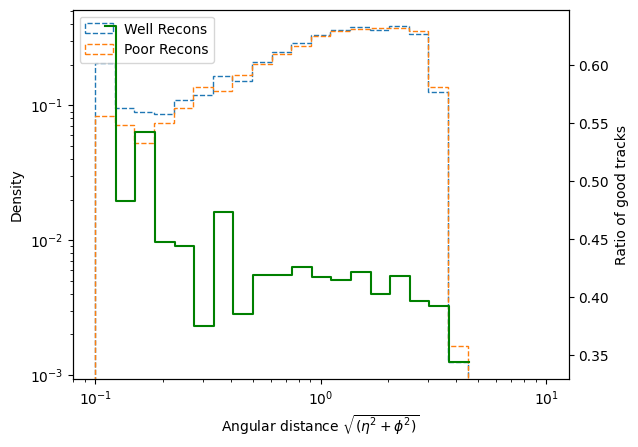

In [10]:
dis_good = []
dis_bad = []
thresh = 0.75
for i in range(np.array(d_angle).shape[0]):
    if not d_angle[i] == torch.tensor(torch.inf):
        if d_angle[i] == 0 : continue
        if scores[i] >= thresh:
            dis_good.append(d_angle[i])
        else:
            dis_bad.append(d_angle[i])

print(len(dis_good))
print(len(dis_bad))

fig,ax1 = plt.subplots()
#range = (0,0.0035)
print(f"Minima distance for good tracks: {np.nanmin(dis_good)}")
print(f"Minima distance for bad tracks: {np.nanmin(dis_bad)}")
print(f"Maxima distance for good tracks: {np.nanmax(dis_good)}")
print(f"Maxima distance for bad tracks: {np.nanmax(dis_bad)}")
#range_x = np.linspace(0,0.05,16)
range_x = np.logspace(-1,1,24)
ax1.hist(dis_good,bins = range_x,label = "Well Recons",log = True,histtype="step",linestyle = '--',density = True)
ax1.hist(dis_bad,bins = range_x,label = "Poor Recons",log = True,histtype="step",linestyle = '--',density = True)
ax1.legend()
ax2 = ax1.twinx()
ax1.set_xscale('log')
unmatched_hist, matched_bin_edge = np.histogram(dis_bad,bins=range_x)
matched_hist,matched_bin_edge = np.histogram(dis_good,bins=range_x)

rato = np.divide(matched_hist,(matched_hist+unmatched_hist))
print(rato)
step_bins = (matched_bin_edge[0:-1]+matched_bin_edge[1:len(matched_bin_edge)])/2
ax2.step(step_bins,rato,'green',where = "mid",linestyle = '-')

ax1.set_xlabel("Angular distance $\sqrt{(\eta^2 + \phi^2)}$")
ax1.set_ylabel("Density")
ax2.set_ylabel("Ratio of good tracks")